In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
# path to data
path = pathlib.PosixPath("../data/png_unscaled_data")

In [ ]:
# validation set percentage
valid_pct=0.2
# picture size
size = 224
# fix seed for reproducible data split
seed = 69 #42

In [ ]:
# preprocessing operation done to the pictures
# https://pillow.readthedocs.io/en/stable/reference/ImageOps.html
def picturePreprocessing(image):
    # converts picture to greyscale
    image = PIL.ImageOps.grayscale(image)
    # takes the negativ of the picture so that black is the background color
    image = PIL.ImageOps.invert(image)
    return image

In [ ]:
# imports a list of pictures
il = ImageList.from_folder(path, after_open=picturePreprocessing)
# splits into train/test and adds labels
src = il.split_by_rand_pct(valid_pct, seed=seed).label_from_folder()
# builds a databunch
data = ImageDataBunch.create_from_ll(src, size=size, num_workers=8, resize_method=ResizeMethod.SQUISH, padding_mode='zeros').normalize(imagenet_stats)

In [ ]:
# load model
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.load("only64_unfreezed")

In [ ]:
# accuracy of the model
#learn.validate()[1].item()

In [ ]:
# get various informations on the network
interpreter = learn.interpret()

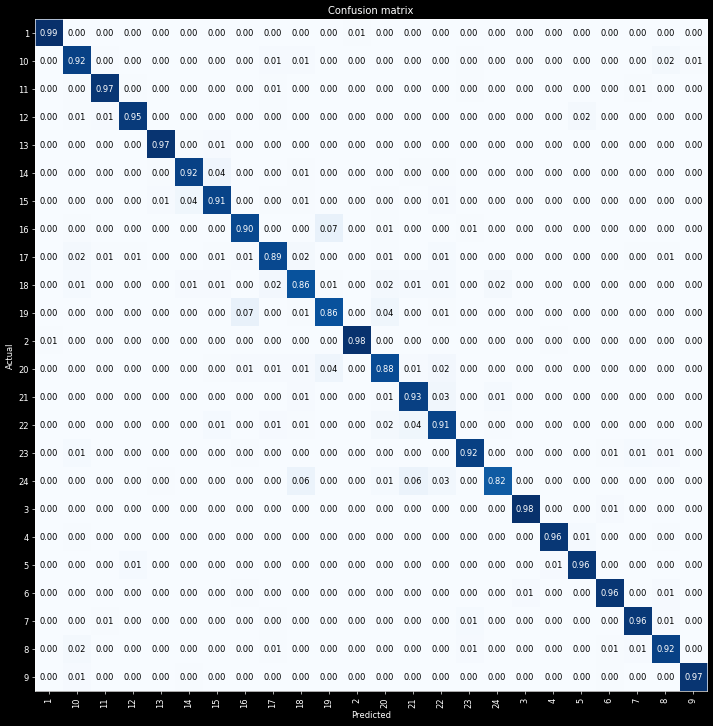

In [46]:
# confusion matrix of the model
interpreter.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=60)

In [69]:
# function inspired by plot_top_loss
# plots k random elements from the validation set
def _plot_batch(self, k, largest=True, figsize=(12,12), heatmap:bool=False, heatmap_thresh:int=16, 
                            alpha:float=0.6, cmap:str="magma", show_text:bool=True,
                            return_fig:bool=None)->Optional[plt.Figure]:
    "Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class."
    if heatmap is None: heatmap = _test_cnn(self.learn.model)
    size_validDataset = len(self.data.dl(self.ds_type))
    tl_idx = torch.LongTensor(k).random_(0, size_validDataset-1)
    classes = self.data.classes
    cols = math.ceil(math.sqrt(k))
    rows = math.ceil(k/cols)
    fig,axes = plt.subplots(rows, cols, figsize=figsize)
    for i,idx in enumerate(tl_idx):
        im,cl = self.data.dl(self.ds_type).dataset[idx]
        cl = int(cl)
        title = f'predicted:{classes[self.pred_class[idx]]}\nactual:{classes[cl]}\nconfidence:{self.preds[idx][self.pred_class[idx]]:.2f}' if show_text else None
        im.show(ax=axes.flat[i], title=title)
        if heatmap:
            mult = self.GradCAM(idx,self.ds_type,heatmap_thresh,image=False)
            if mult is not None:
                sz = list(im.shape[-2:])
                axes.flat[i].imshow(mult, alpha=alpha, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap=cmap)
    if ifnone(return_fig, defaults.return_fig): return fig
# add methods to the class
ClassificationInterpretation.plot_batch = _plot_batch

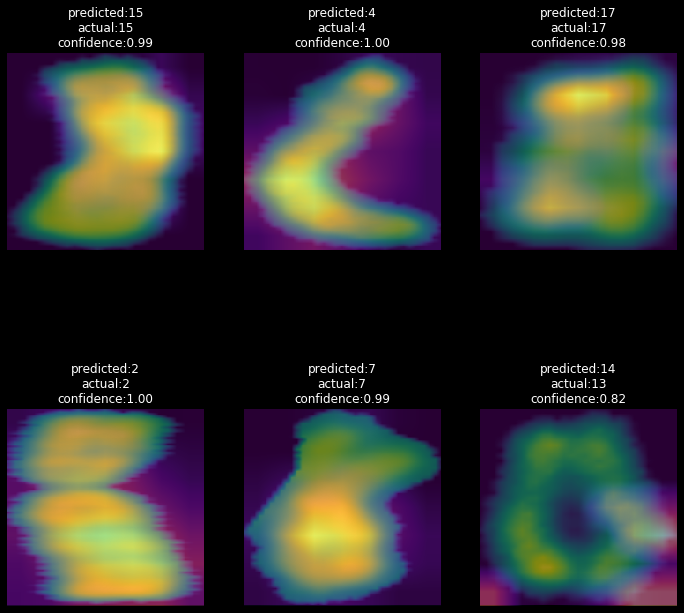

In [72]:
# some random pictures and their interpretation
interpreter.plot_batch(6, heatmap=True, alpha=0.4)

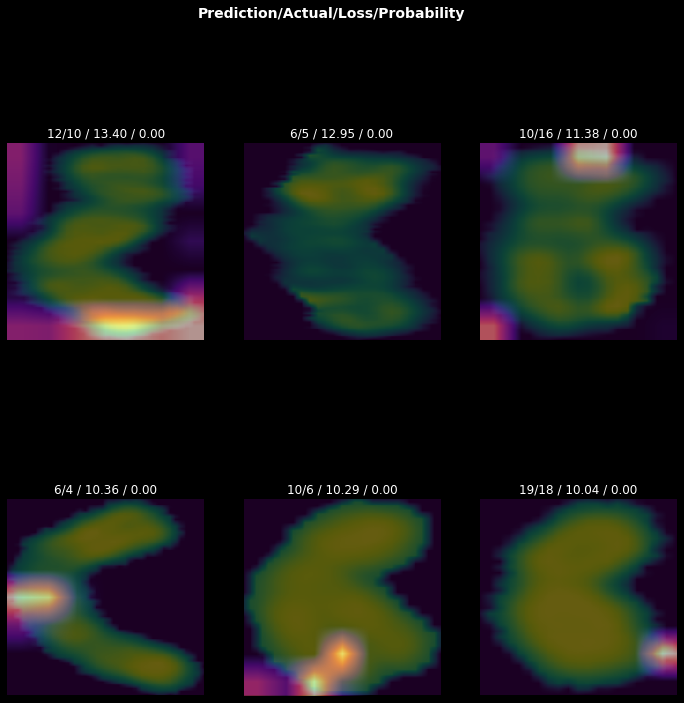

In [48]:
# most confident misclassifications (with overlaying heatmap)
# predicted class / actual class / loss / probability of actual class
interpreter.plot_top_losses(6, heatmap=True)